<a href="https://colab.research.google.com/github/nsriniva/DS-Unit-1-Build/blob/master/DS_Unit_1_BuildProject_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [103]:
from math import isclose
import zipfile 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression


# Uploaded 
# https://archive.ics.uci.edu/ml/machine-learning-databases/00332/OnlineNewsPopularity.zip 
# to Google Drive from 
# https://archive.ics.uci.edu/ml/datasets/Online+News+Popularity

# Extract data file from archive and load into dataframe
# The xip archive contains the data file 
# OnlineNewsPopularity/OnlineNewsPopularity.csv 
# and the info file 
# OnlineNewsPopularity/OnlineNewsPopularity.names.
# My Google Drive is mounted at /content/drive/My Drive
zfile = '/content/drive/My Drive/OnlineNewsPopularity.zip'
# Use the zipfile package to open the archive and read the data file
with zipfile.ZipFile(zfile) as zf:
  with zf.open('OnlineNewsPopularity/OnlineNewsPopularity.csv') as f:
    onp_df = pd.read_csv(f)

In [104]:
#display(onp_df.shape, onp_df.head())

null_values = onp_df.isna().sum().sum()

print(f"There are {['','no'][null_values==0]} invalid values in the dataset!")

column_names = (x.strip() for x in onp_df.columns)

onp_df.columns = list(column_names)

display(onp_df.head(), onp_df.shape)

#display(list(onp_df.columns))

There are no invalid values in the dataset!


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  """


,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,num_keywords,data_channel_is_lifestyle,data_channel_is_entertainment,data_channel_is_bus,data_channel_is_socmed,data_channel_is_tech,data_channel_is_world,kw_min_min,kw_max_min,kw_avg_min,kw_min_max,kw_max_max,kw_avg_max,kw_min_avg,kw_max_avg,kw_avg_avg,self_reference_min_shares,self_reference_max_shares,self_reference_avg_sharess,weekday_is_monday,weekday_is_tuesday,weekday_is_wednesday,weekday_is_thursday,weekday_is_friday,weekday_is_saturday,weekday_is_sunday,is_weekend,LDA_00,LDA_01,LDA_02,LDA_03,LDA_04,global_subjectivity,global_sentiment_polarity,global_rate_positive_words,global_rate_negative_words,rate_positive_words,rate_negative_words,avg_positive_polarity,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
0,http://mashable.com/2013/01/07/amazon-instant-...,731.0,12.0,219.0,0.663594,1.0,0.815385,4.0,2.0,1.0,0.0,4.680365,5.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,496.0,496.0,496.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.500331,0.378279,0.040005,0.041263,0.040123,0.521617,0.092562,0.045662,0.013699,0.769231,0.230769,0.378636,0.100000,0.7,-0.350000,-0.600,-0.200000,0.500000,-0.187500,0.000000,0.187500,593
1,http://mashable.com/2013/01/07/ap-samsung-spon...,731.0,9.0,255.0,0.604743,1.0,0.791946,3.0,1.0,1.0,0.0,4.913725,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.799756,0.050047,0.050096,0.050101,0.050001,0.341246,0.148948,0.043137,0.015686,0.733333,0.266667,0.286915,0.033333,0.7,-0.118750,-0.125,-0.100000,0.000000,0.000000,0.500000,0.000000,711
2,http://mashable.com/2013/01/07/apple-40-billio...,731.0,9.0,211.0,0.575130,1.0,0.663866,3.0,1.0,1.0,0.0,4.393365,6.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,918.0,918.0,918.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.217792,0.033334,0.033351,0.033334,0.682188,0.702222,0.323333,0.056872,0.009479,0.857143,0.142857,0.495833,0.100000,1.0,-0.466667,-0.800,-0.133333,0.000000,0.000000,0.500000,0.000000,1500
3,http://mashable.com/2013/01/07/astronaut-notre...,731.0,9.0,531.0,0.503788,1.0,0.665635,9.0,0.0,1.0,0.0,4.404896,7.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.028573,0.419300,0.494651,0.028905,0.028572,0.429850,0.100705,0.041431,0.020716,0.666667,0.333333,0.385965,0.136364,0.8,-0.369697,-0.600,-0.166667,0.000000,0.000000,0.500000,0.000000,1200
4,http://mashable.com/2013/01/07/att-u-verse-apps/,731.0,13.0,1072.0,0.415646,1.0,0.540890,19.0,19.0,20.0,0.0,4.682836,7.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,545.0,16000.0,3151.157895,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.028633,0.028794,0.028575,0.028572,0.885427,0.513502,0.281003,0.074627,0.012127,0.860215,0.139785,0.411127,0.033333,1.0,-0.220192,-0.500,-0.050000,0.454545,0.136364,0.045455,0.136364,505


(39644, 61)

In [105]:

# Combine all data_channel_is_*/weekday_is_* columns into one single categorical 
# column 'data_channel'/'weekday'

# First, identify all the data_channel_is_*/weekday_is_* columns
data_channel_columns = list(filter(lambda x: x.startswith('data_channel_is_'), onp_df.columns))
weekday_columns = list(filter(lambda x: x.startswith('weekday_is_'), onp_df.columns))

display(data_channel_columns)
display(weekday_columns)

['data_channel_is_lifestyle',
 'data_channel_is_entertainment',
 'data_channel_is_bus',
 'data_channel_is_socmed',
 'data_channel_is_tech',
 'data_channel_is_world']

['weekday_is_monday',
 'weekday_is_tuesday',
 'weekday_is_wednesday',
 'weekday_is_thursday',
 'weekday_is_friday',
 'weekday_is_saturday',
 'weekday_is_sunday']

In [106]:
# Compute a mapping between the data channel/weekday name and an integer
# value i.e. 'lifestyle':1/'monday':1, ... 
dcm = {}
wm = {}

prel = len('data_channel_is_')
for idx,name in enumerate(data_channel_columns):
  dcm[name[prel:]] = idx+1

prel = len('weekday_is_')
for idx,name in enumerate(weekday_columns):
  wm[name[prel:]] = idx+1

#display(dcm)
#display(wm)

mf = lambda u,args: [0,args][int(u)]

# This function adds a new column named new_col with the information
# from all the columns prefixed with new_col+'_is_' and then returns a
# dataframe with all them dropped.
def mapper_func(df, new_col, name_dict):

  name_list = list(name_dict.items())

  first = name_list[0]

  df[new_col] = df[new_col+'_is_'+first[0]].apply(mf, args=(name_dict[first[0]],))

  for name,_ in name_list[1:]:
    df[new_col] = df[new_col] + df[new_col+'_is_'+name].apply(mf, args=(name_dict[name],))

  return df.drop(columns=[ new_col+'_is_'+name for name,_ in name_list])


onp_df = mapper_func(onp_df, 'data_channel', dcm)

onp_df = mapper_func(onp_df, 'weekday', wm)

onp_df = onp_df.drop(columns=['is_weekend'])

# Remove both non-predictive attributes
onp_df_predictive = onp_df.drop(columns=['url', 'timedelta'])

# Drop the target/goal attribute
onp_df_predictive = onp_df_predictive.drop(columns=['shares'])

display(onp_df_predictive.head(), onp_df_predictive.shape)

,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,num_keywords,kw_min_min,kw_max_min,kw_avg_min,kw_min_max,kw_max_max,kw_avg_max,kw_min_avg,kw_max_avg,kw_avg_avg,self_reference_min_shares,self_reference_max_shares,self_reference_avg_sharess,LDA_00,LDA_01,LDA_02,LDA_03,LDA_04,global_subjectivity,global_sentiment_polarity,global_rate_positive_words,global_rate_negative_words,rate_positive_words,rate_negative_words,avg_positive_polarity,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,data_channel,weekday
0,12.0,219.0,0.663594,1.0,0.815385,4.0,2.0,1.0,0.0,4.680365,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,496.0,496.0,496.000000,0.500331,0.378279,0.040005,0.041263,0.040123,0.521617,0.092562,0.045662,0.013699,0.769231,0.230769,0.378636,0.100000,0.7,-0.350000,-0.600,-0.200000,0.500000,-0.187500,0.000000,0.187500,2,1
1,9.0,255.0,0.604743,1.0,0.791946,3.0,1.0,1.0,0.0,4.913725,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.799756,0.050047,0.050096,0.050101,0.050001,0.341246,0.148948,0.043137,0.015686,0.733333,0.266667,0.286915,0.033333,0.7,-0.118750,-0.125,-0.100000,0.000000,0.000000,0.500000,0.000000,3,1
2,9.0,211.0,0.575130,1.0,0.663866,3.0,1.0,1.0,0.0,4.393365,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,918.0,918.0,918.000000,0.217792,0.033334,0.033351,0.033334,0.682188,0.702222,0.323333,0.056872,0.009479,0.857143,0.142857,0.495833,0.100000,1.0,-0.466667,-0.800,-0.133333,0.000000,0.000000,0.500000,0.000000,3,1
3,9.0,531.0,0.503788,1.0,0.665635,9.0,0.0,1.0,0.0,4.404896,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.028573,0.419300,0.494651,0.028905,0.028572,0.429850,0.100705,0.041431,0.020716,0.666667,0.333333,0.385965,0.136364,0.8,-0.369697,-0.600,-0.166667,0.000000,0.000000,0.500000,0.000000,2,1
4,13.0,1072.0,0.415646,1.0,0.540890,19.0,19.0,20.0,0.0,4.682836,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,545.0,16000.0,3151.157895,0.028633,0.028794,0.028575,0.028572,0.885427,0.513502,0.281003,0.074627,0.012127,0.860215,0.139785,0.411127,0.033333,1.0,-0.220192,-0.500,-0.050000,0.454545,0.136364,0.045455,0.136364,5,1


(39644, 46)

In [107]:
# We now add a new binary valued column popular, with each row having a value
# of 1, if the corresponding shares value >=1400 and 0 otherwise.
onp_df_predictive['popular'] = onp_df.shares >= 1400
onp_df_predictive.popular.value_counts()

True     21154
False    18490
Name: popular, dtype: int64

In [108]:
grouped = onp_df_predictive.groupby(onp_df_predictive.popular)

pop0_df = grouped.get_group(0)

pop1_df = grouped.get_group(1)

display(pop0_df.head(), pop0_df.shape)

display(pop1_df.head(), pop1_df.shape)


,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,num_keywords,kw_min_min,kw_max_min,kw_avg_min,kw_min_max,kw_max_max,kw_avg_max,kw_min_avg,kw_max_avg,kw_avg_avg,self_reference_min_shares,self_reference_max_shares,self_reference_avg_sharess,LDA_00,LDA_01,LDA_02,LDA_03,LDA_04,global_subjectivity,global_sentiment_polarity,global_rate_positive_words,global_rate_negative_words,rate_positive_words,rate_negative_words,avg_positive_polarity,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,data_channel,weekday,popular
0,12.0,219.0,0.663594,1.0,0.815385,4.0,2.0,1.0,0.0,4.680365,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,496.0,496.0,496.000000,0.500331,0.378279,0.040005,0.041263,0.040123,0.521617,0.092562,0.045662,0.013699,0.769231,0.230769,0.378636,0.100000,0.7,-0.350000,-0.600,-0.200000,0.500000,-0.187500,0.000000,0.187500,2,1,False
1,9.0,255.0,0.604743,1.0,0.791946,3.0,1.0,1.0,0.0,4.913725,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.799756,0.050047,0.050096,0.050101,0.050001,0.341246,0.148948,0.043137,0.015686,0.733333,0.266667,0.286915,0.033333,0.7,-0.118750,-0.125,-0.100000,0.000000,0.000000,0.500000,0.000000,3,1,False
3,9.0,531.0,0.503788,1.0,0.665635,9.0,0.0,1.0,0.0,4.404896,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.028573,0.419300,0.494651,0.028905,0.028572,0.429850,0.100705,0.041431,0.020716,0.666667,0.333333,0.385965,0.136364,0.8,-0.369697,-0.600,-0.166667,0.000000,0.000000,0.500000,0.000000,2,1,False
4,13.0,1072.0,0.415646,1.0,0.540890,19.0,19.0,20.0,0.0,4.682836,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,545.0,16000.0,3151.157895,0.028633,0.028794,0.028575,0.028572,0.885427,0.513502,0.281003,0.074627,0.012127,0.860215,0.139785,0.411127,0.033333,1.0,-0.220192,-0.500,-0.050000,0.454545,0.136364,0.045455,0.136364,5,1,False
5,10.0,370.0,0.559889,1.0,0.698198,2.0,2.0,0.0,0.0,4.359459,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8500.0,8500.0,8500.000000,0.022245,0.306718,0.022231,0.022224,0.626582,0.437409,0.071184,0.029730,0.027027,0.523810,0.476190,0.350610,0.136364,0.6,-0.195000,-0.400,-0.100000,0.642857,0.214286,0.142857,0.214286,5,1,False


(18490, 47)

,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,num_keywords,kw_min_min,kw_max_min,kw_avg_min,kw_min_max,kw_max_max,kw_avg_max,kw_min_avg,kw_max_avg,kw_avg_avg,self_reference_min_shares,self_reference_max_shares,self_reference_avg_sharess,LDA_00,LDA_01,LDA_02,LDA_03,LDA_04,global_subjectivity,global_sentiment_polarity,global_rate_positive_words,global_rate_negative_words,rate_positive_words,rate_negative_words,avg_positive_polarity,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,data_channel,weekday,popular
2,9.0,211.0,0.575130,1.0,0.663866,3.0,1.0,1.0,0.0,4.393365,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,918.0,918.0,918.0,0.217792,0.033334,0.033351,0.033334,0.682188,0.702222,0.323333,0.056872,0.009479,0.857143,0.142857,0.495833,0.10,1.0,-0.466667,-0.800,-0.133333,0.000,0.0,0.500,0.0,3,1,True
8,11.0,97.0,0.670103,1.0,0.836735,2.0,0.0,0.0,0.0,4.855670,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.458250,0.028979,0.028662,0.029696,0.454412,0.538889,0.161111,0.030928,0.020619,0.600000,0.400000,0.566667,0.40,0.8,-0.125000,-0.125,-0.125000,0.125,0.0,0.375,0.0,5,1,True
10,9.0,1248.0,0.490050,1.0,0.731638,11.0,0.0,1.0,0.0,4.617788,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.025004,0.287301,0.400829,0.261864,0.025002,0.482060,0.102350,0.038462,0.020833,0.648649,0.351351,0.404480,0.10,1.0,-0.415064,-1.000,-0.100000,0.000,0.0,0.500,0.0,6,1,True
11,10.0,187.0,0.666667,1.0,0.800000,7.0,0.0,1.0,0.0,4.657754,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.028628,0.028573,0.028596,0.028715,0.885488,0.477165,0.150000,0.026738,0.010695,0.714286,0.285714,0.435000,0.20,0.7,-0.262500,-0.400,-0.125000,0.000,0.0,0.500,0.0,1,1,True
13,9.0,285.0,0.744186,1.0,0.841530,4.0,2.0,0.0,21.0,4.343860,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,770.0,22800.0,11785.0,0.033386,0.033427,0.033352,0.866499,0.033337,0.509744,-0.053085,0.028070,0.052632,0.347826,0.652174,0.457500,0.16,1.0,-0.337889,-0.700,-0.100000,1.000,-1.0,0.500,1.0,0,1,True


(21154, 47)

In [109]:
# We run 2 sample t-tests for each attribute between the popular and not popular
# sites to determine the most influential attributes.

# We use a confidence level of 99% = 0.99
# => pvalue = 1 - 0.99 = 0.01

# If the ttest for an issue returns a pvalue < 0.01, then we can reject the 
# Null hypothesis i.e. We can say, with a 99% confidence level, that the 
# attribute has an effect on the popularity of the web site.


issues_diff = []
issues_sim = []
issues_tossup = []

for issue in pop1_df.columns:
  if issue == 'popular':
    continue
  res = stats.ttest_ind(pop1_df[issue], pop0_df[issue])
  if res.pvalue < 0.01:
    issues_diff.append(issue)
  elif res.pvalue > 0.1:
    issues_sim.append(issue)
  else:
    issues_tossup.append(issue)

display(issues_tossup)

if len(issues_diff):
  # These issues have a pvalue < 0.01 i.e. the Null hypothesis can
  # be rejected and they have an effect on the popularity of the 
  # article.
  print('The following attributes do impact popularity:')
  display(issues_diff)

if len(issues_sim) > 0:
  # These issues have a pvalue > 0.1 i.e. the Null hypothesis cannot be 
  # rejected and the difference is not significant at the 90% level.
  print('The following attributes do not impact popularity:')
  display(issues_sim)


[]

The following attributes do impact popularity:


['n_tokens_title',
 'n_tokens_content',
 'num_hrefs',
 'num_self_hrefs',
 'num_imgs',
 'average_token_length',
 'num_keywords',
 'kw_min_min',
 'kw_max_min',
 'kw_avg_min',
 'kw_max_max',
 'kw_avg_max',
 'kw_min_avg',
 'kw_max_avg',
 'kw_avg_avg',
 'self_reference_min_shares',
 'self_reference_max_shares',
 'self_reference_avg_sharess',
 'LDA_00',
 'LDA_01',
 'LDA_02',
 'LDA_03',
 'LDA_04',
 'global_subjectivity',
 'global_sentiment_polarity',
 'global_rate_positive_words',
 'global_rate_negative_words',
 'rate_positive_words',
 'rate_negative_words',
 'avg_positive_polarity',
 'min_positive_polarity',
 'max_positive_polarity',
 'title_subjectivity',
 'title_sentiment_polarity',
 'abs_title_sentiment_polarity',
 'data_channel',
 'weekday']

The following attributes do not impact popularity:


['n_unique_tokens',
 'n_non_stop_words',
 'n_non_stop_unique_tokens',
 'num_videos',
 'kw_min_max',
 'avg_negative_polarity',
 'min_negative_polarity',
 'max_negative_polarity',
 'abs_title_subjectivity']

In [110]:
onp_df_relevant = onp_df_predictive[issues_diff]
display(onp_df_relevant.head(), onp_df_relevant.shape)

,n_tokens_title,n_tokens_content,num_hrefs,num_self_hrefs,num_imgs,average_token_length,num_keywords,kw_min_min,kw_max_min,kw_avg_min,kw_max_max,kw_avg_max,kw_min_avg,kw_max_avg,kw_avg_avg,self_reference_min_shares,self_reference_max_shares,self_reference_avg_sharess,LDA_00,LDA_01,LDA_02,LDA_03,LDA_04,global_subjectivity,global_sentiment_polarity,global_rate_positive_words,global_rate_negative_words,rate_positive_words,rate_negative_words,avg_positive_polarity,min_positive_polarity,max_positive_polarity,title_subjectivity,title_sentiment_polarity,abs_title_sentiment_polarity,data_channel,weekday
0,12.0,219.0,4.0,2.0,1.0,4.680365,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,496.0,496.0,496.000000,0.500331,0.378279,0.040005,0.041263,0.040123,0.521617,0.092562,0.045662,0.013699,0.769231,0.230769,0.378636,0.100000,0.7,0.500000,-0.187500,0.187500,2,1
1,9.0,255.0,3.0,1.0,1.0,4.913725,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.799756,0.050047,0.050096,0.050101,0.050001,0.341246,0.148948,0.043137,0.015686,0.733333,0.266667,0.286915,0.033333,0.7,0.000000,0.000000,0.000000,3,1
2,9.0,211.0,3.0,1.0,1.0,4.393365,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,918.0,918.0,918.000000,0.217792,0.033334,0.033351,0.033334,0.682188,0.702222,0.323333,0.056872,0.009479,0.857143,0.142857,0.495833,0.100000,1.0,0.000000,0.000000,0.000000,3,1
3,9.0,531.0,9.0,0.0,1.0,4.404896,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.028573,0.419300,0.494651,0.028905,0.028572,0.429850,0.100705,0.041431,0.020716,0.666667,0.333333,0.385965,0.136364,0.8,0.000000,0.000000,0.000000,2,1
4,13.0,1072.0,19.0,19.0,20.0,4.682836,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,545.0,16000.0,3151.157895,0.028633,0.028794,0.028575,0.028572,0.885427,0.513502,0.281003,0.074627,0.012127,0.860215,0.139785,0.411127,0.033333,1.0,0.454545,0.136364,0.136364,5,1


(39644, 37)

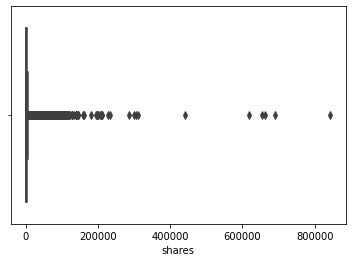

In [111]:
import seaborn as sns
sns.boxplot(x=onp_df.shares);

In [112]:
#Let's try some linear regression

X = onp_df_relevant.values

Y = onp_df.shares.values.reshape(-1,1)

lr = LinearRegression()

lr.fit(X, Y)

Yc = lr.predict(X)

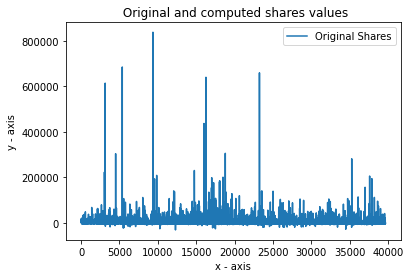

In [113]:
Xv = list(onp_df.index)

plt.plot(Xv, Y-Yc, label = 'Original Shares')

#plt.plot(Xv, Yc, label='Computed Shares')
plt.xlabel('x - axis')
# Set the y axis label of the current axis.
plt.ylabel('y - axis')
# Set a title of the current axes.
plt.title(' Original and computed shares values')
# show a legend on the plot
plt.legend()
# Display a figure.
plt.show()

In [114]:
z = np.abs(stats.zscore(Y))
print(z)

[[0.24102756]
 [0.23087859]
 [0.16301816]
 ...
 [0.12861489]
 [0.19742142]
 [0.18021979]]


In [115]:
outliers = np.where(z>3)[0]

In [121]:
onp_df_no_outliers = onp_df_relevant.drop(outliers).reindex()

X_no_outliers = onp_df_no_outliers.values
Y_no_outliers = onp_df.drop(outliers).shares.reindex()
Y_no_outliers = Y_no_outliers.values
display(Y_no_outliers.shape)

display(onp_df_no_outliers.shape, onp_df_no_outliers.head())

(39336,)

(39336, 37)

,n_tokens_title,n_tokens_content,num_hrefs,num_self_hrefs,num_imgs,average_token_length,num_keywords,kw_min_min,kw_max_min,kw_avg_min,kw_max_max,kw_avg_max,kw_min_avg,kw_max_avg,kw_avg_avg,self_reference_min_shares,self_reference_max_shares,self_reference_avg_sharess,LDA_00,LDA_01,LDA_02,LDA_03,LDA_04,global_subjectivity,global_sentiment_polarity,global_rate_positive_words,global_rate_negative_words,rate_positive_words,rate_negative_words,avg_positive_polarity,min_positive_polarity,max_positive_polarity,title_subjectivity,title_sentiment_polarity,abs_title_sentiment_polarity,data_channel,weekday
0,12.0,219.0,4.0,2.0,1.0,4.680365,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,496.0,496.0,496.000000,0.500331,0.378279,0.040005,0.041263,0.040123,0.521617,0.092562,0.045662,0.013699,0.769231,0.230769,0.378636,0.100000,0.7,0.500000,-0.187500,0.187500,2,1
1,9.0,255.0,3.0,1.0,1.0,4.913725,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.799756,0.050047,0.050096,0.050101,0.050001,0.341246,0.148948,0.043137,0.015686,0.733333,0.266667,0.286915,0.033333,0.7,0.000000,0.000000,0.000000,3,1
2,9.0,211.0,3.0,1.0,1.0,4.393365,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,918.0,918.0,918.000000,0.217792,0.033334,0.033351,0.033334,0.682188,0.702222,0.323333,0.056872,0.009479,0.857143,0.142857,0.495833,0.100000,1.0,0.000000,0.000000,0.000000,3,1
3,9.0,531.0,9.0,0.0,1.0,4.404896,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.028573,0.419300,0.494651,0.028905,0.028572,0.429850,0.100705,0.041431,0.020716,0.666667,0.333333,0.385965,0.136364,0.8,0.000000,0.000000,0.000000,2,1
4,13.0,1072.0,19.0,19.0,20.0,4.682836,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,545.0,16000.0,3151.157895,0.028633,0.028794,0.028575,0.028572,0.885427,0.513502,0.281003,0.074627,0.012127,0.860215,0.139785,0.411127,0.033333,1.0,0.454545,0.136364,0.136364,5,1


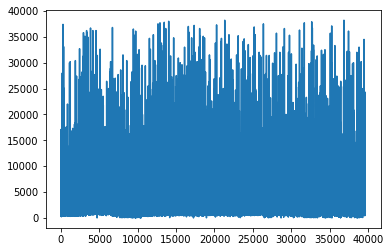

In [119]:
Xv_no_outliers = list(onp_df_no_outliers.index)
plt.plot(Xv_no_outliers, Y_no_outliers, label = 'Original Shares')

In [124]:
lr = LinearRegression()

lr.fit(X_no_outliers, Y_no_outliers)

Yc_no_outliers = lr.predict(X_no_outliers)

(39336, 1)

0    8.275623e+07
dtype: float64

0    2103.829301
dtype: float64

19.292362596694694

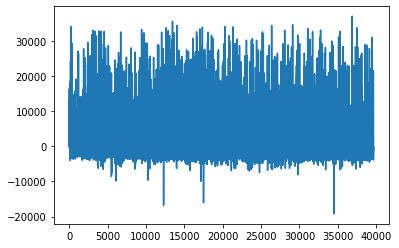

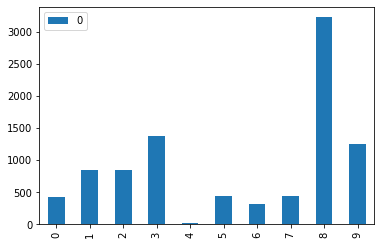

In [136]:
error_no_outliers = Y_no_outliers - Yc_no_outliers

plt.plot(Xv_no_outliers, Y_no_outliers-Yc_no_outliers, label = 'Original Shares')

error = pd.DataFrame(abs(Y_no_outliers - Yc_no_outliers))

display(error.shape, error.sum(), error.sum()/error.shape[0])
error[:10].plot(kind='bar')

mean_rmse = np.linalg.norm(Y_no_outliers-Yc_no_outliers)/len(Y_no_outliers)

display(mean_rmse)